# Introducing Data Science Workflows 

In [49]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [50]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Preprocessing the Data

In [51]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [52]:
def preprocessing_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ["Age_categories", "Fare_categories",
                             "Title", "Cabin_type", "Sex"]:
        
        df = create_dummies(df, col)
    
    return df

train = preprocessing_df(train)
holdout = preprocessing_df(holdout)

# Exploring the Data

In [53]:
explore_cols = ["SibSp", "Parch", "Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


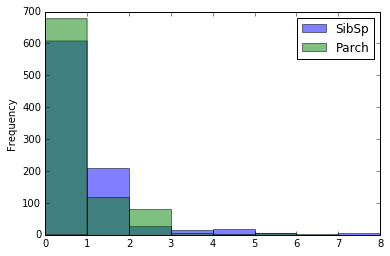

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

explore.drop("Survived", axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()


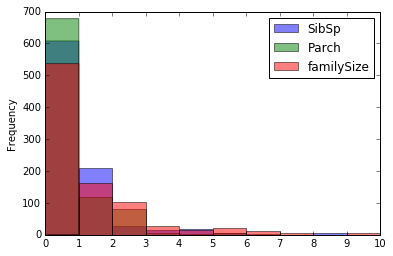

In [55]:
explore["familySize"] = explore[["SibSp", "Parch"]].sum(axis=1)
explore.drop("Survived", axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

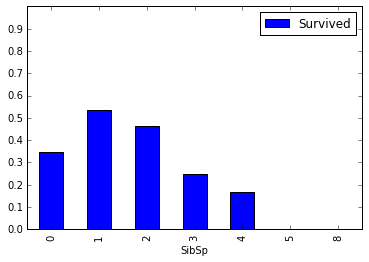

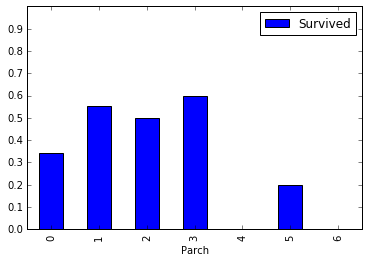

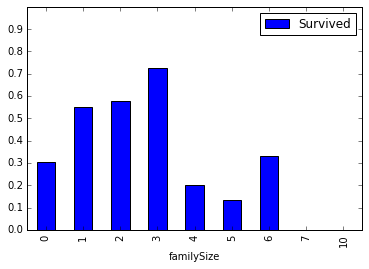

In [56]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
#     plt.axhspan(.3, .6, alpha=0.2, color='red')
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.show()

The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in thise case is similar (skewed right), however, there are less values being zero, and the quantity tapers off less rapidly as the values increases.

Looking at the survival rates of the combined family members, you can see that few of the over 500 passengers(30%) with no family survived, while greater numbers of passengers with family members survived.

# Engineering New Features
Only 30% of the passengers who had no family members onboard survived.  We can come up with an idea for a new feature - was the passenger alone: 
- `1` if the passenger has zero family members onboard
- `0` if the passenger has one or more family members onboard

In [57]:
def process_isAlone(df):
    df["familySize"] = df[["SibSp", "Parch"]].sum(axis=1)
    df['isAlone'] = 0
    df.loc[(df["familySize"] == 0), "isAlone"] = 1
    df = df.drop("familySize", axis=1)
    return df

train = process_isAlone(train)
holdout = process_isAlone(holdout)

# Selecting the Best-Performing Features

In [64]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*len(best_columns)+"\n{}\n".format(best_columns))
    return best_columns

optimized_columns = select_features(train)


Best Columns 
------------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isAlone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


# Selecting and Tuning Different Algorithms

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df, features, target):
    all_X = df[features]
    all_y = df[target]
    models = [
        {
            "name":"KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
                }
        },
        {
            "name":"LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":{
                "solver":["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name":"RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":{
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }]
    
    for model in models:
        print(model["name"])
        print("-"*len(model["name"]))
        
        grid = GridSearchCV(model["estimator"], param_grid=model["hyperparameters"], cv=10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
    
    return models

result = select_model(train, optimized_columns, "Survived")

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'weights': 'uniform', 'p': 1, 'n_neighbors': 5}

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

RandomForestClassifier
----------------------
Best Score: 0.8395061728395061
Best Parameters: {'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 10, 'n_estimators': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}



In [69]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    submission_df = {"PassengerId": holdout["PassengerId"],
                    "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index=False)
    
    
best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, optimized_columns)

# Next Steps to perform

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the `select_model()` function, like `support vector machines`, `stochastic gradient descent` or `perceptron` linear models.
- Experiment with `RandomizedSearchCV` instead of `GridSearchCV` to speed up your `select_features()` function.